# Match PC coordinates to Robberto frame

In [24]:
from pathlib import Path
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u

In [2]:
datapath = Path.cwd().parent / "data" 
fname1 = "hst-acs-f658n-trap-south-2005_BGSUB"
fname2 = "pcmos-f631n_sharp_16"
sname1 = "fwhm4.0-thresh20"
sname2 = "fwhm4.0-thresh5"

In [3]:
hdu1, = fits.open(datapath / f"{fname1}.fits")
hdu2, = fits.open(datapath / f"{fname2}.fits")
w1 = WCS(hdu1.header)
w2 = WCS(hdu2.header)
stab1 = Table.read(datapath / f"{fname1}-sources-{sname1}.ecsv")
stab2 = Table.read(datapath / f"{fname2}-sources-{sname2}.ecsv")

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


In [4]:
c1 = w1.pixel_to_world(stab1["xcentroid"], stab1["ycentroid"])
c2 = w2.pixel_to_world(stab2["xcentroid"], stab2["ycentroid"])

In [5]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
c1_matches = c1[sep_constraint]
c2_matches = c2[idx[sep_constraint]]
f"Out of {len(c1)} sources in catalog #1 we have {len(c1_matches)} in catalog #2, but only {len(set(idx[sep_constraint]))} are unique."

'Out of 404 sources in catalog #1 we have 149 in catalog #2, but only 67 are unique.'

In [6]:
stab1_matches = stab1[sep_constraint]
stab2_matches = stab2[idx[sep_constraint]]

In [7]:
def match_catalogs(c1, c2, max_sep=1.0 * u.arcsec):
    """Find indices of coincident sources between two lists of sky coordinates
    
    Returns a pair of index arrays of the matched sources in each catalog.
    Each source is guaranteed to appear only once.
    """
    # Find closest source in c2 to each source in c1
    idx2, d2d, d3d = c1.match_to_catalog_sky(c2)
    # Make index of sources in c1: [0, 1, 2, ...]
    idx1 = np.arange(len(c1))
    # Mask that is True when closest source is close enough for match
    isclose = d2d < max_sep
    # Remove duplicate sources in the idx2 list by making a BACKWARDS mapping from 2 -> 1
    # This will keep only the last source in c2 that was matched by a source in c1
    backmap = dict(zip(idx2[isclose], idx1[isclose]))
    # Retrieve the two matched index lists from the dict
    imatch2, imatch1 = zip(*backmap.items())
    # Return arrays of matched indices, which can be used to obtain the matched sources
    return np.asarray(imatch1), np.asarray(imatch2)

In [8]:
ii1, ii2 = match_catalogs(c1, c2, max_sep=max_sep)

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [11]:
c1m = c1[ii1]
c2m = c2[ii2]
seps = c1m.separation(c2m)
np.alltrue(seps <= max_sep), seps.arcsec

(True,
 array([0.18262598, 0.28599852, 0.2530671 , 0.22567101, 0.12185405,
        0.11319555, 0.22107381, 0.51802241, 0.33566328, 0.25572604,
        0.10725601, 0.08154259, 0.13196639, 0.20348143, 0.14673164,
        0.18109066, 0.11089218, 0.16147397, 0.23021767, 0.271897  ,
        0.37323425, 0.241769  , 0.16433792, 0.07410147, 0.29338153,
        0.30299781, 0.11865092, 0.11432735, 0.20624553, 0.20556305,
        0.48767207, 0.0748007 , 0.33981284, 0.68374189, 0.50742918,
        0.41641928, 0.89064617, 0.28962476, 0.16159995, 0.83723499,
        0.54360634, 0.18430243, 0.34304458, 0.06161369, 0.4848366 ,
        0.3398794 , 0.26607079, 0.20906826, 0.98970668, 0.20423054,
        0.52233615, 0.81826633, 0.88994772, 0.04627554, 0.5198369 ,
        0.53831539, 0.82404557, 0.9309316 , 0.32502629, 0.48351759,
        0.27051688, 0.22120743, 0.67280604, 0.70539045, 0.60411317,
        0.76535038, 0.08135515]))

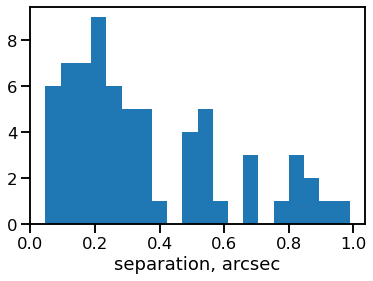

In [12]:
fig, ax = plt.subplots()
ax.hist(seps.arcsec, bins=20)
ax.set(xlabel="separation, arcsec")
...;

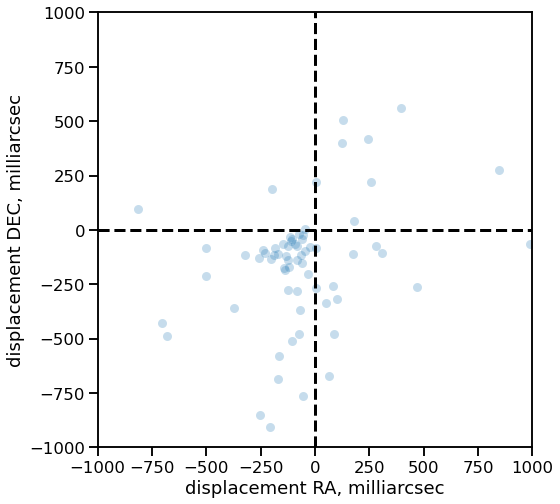

In [14]:
offsets = c1m.spherical_offsets_to(c2m)
ra, dec = [_.milliarcsecond for _ in offsets]
max_sep_mas = max_sep.to(u.milliarcsecond).value
limits = [-max_sep_mas, max_sep_mas]
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.25, linewidths=0)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.set(
    xlim=limits,
    ylim=limits,
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")
...;

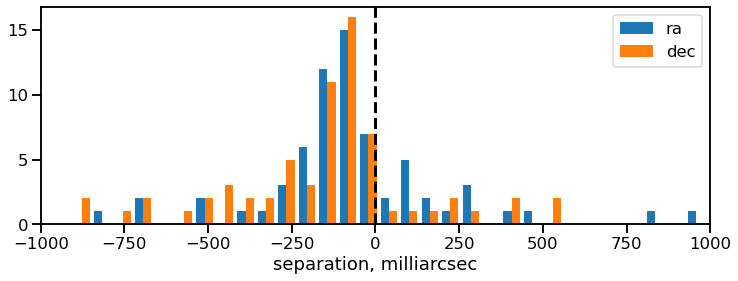

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist([ra, dec], bins=31, label=["ra", "dec"])
ax.set(xlabel="separation, milliarcsec", yscale="linear", xlim=limits)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend()
...;

In [16]:
from astropy.stats import mad_std, sigma_clipped_stats
ra_mean, ra_median, ra_std = sigma_clipped_stats(ra, sigma=2.0)
dec_mean, dec_median, dec_std = sigma_clipped_stats(dec, sigma=2.0)

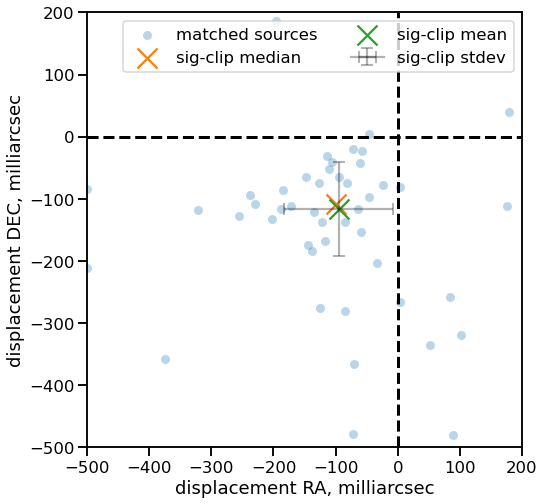

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.3, linewidths=0, label="matched sources")
ax.scatter(ra_median, dec_median, marker="x", s=400, label="sig-clip median")
ax.scatter(ra_mean, dec_mean, marker="x", s=400, label="sig-clip mean")
ax.errorbar(ra_mean, dec_mean, xerr=ra_std, yerr=dec_std, color="k", capsize=6, capthick=2, alpha=0.3, label="sig-clip stdev")
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend(ncol=2)
ax.set(
    xlim=[-500, 200],
    ylim=[-500, 200],
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")

In [26]:
Angle(ra_median * u.milliarcsecond).deg, Angle(dec_median * u.milliarcsecond).deg

(-2.7698404750931005e-05, -2.9884574653204234e-05)

In [27]:
hdu2.header["CRVAL1"] -= Angle(ra_median * u.milliarcsecond).deg
hdu2.header["CRVAL2"] -= Angle(dec_median * u.milliarcsecond).deg

In [28]:
newname2 = f"align-{fname2}"
hdu2.writeto(datapath / f"{newname2}.fits", overwrite=True)

## Repeat for F547M

In [31]:
fname2 = "pcmos-f547m_sharp_16"
hdu2, = fits.open(datapath / f"{fname2}.fits")
w2 = WCS(hdu2.header)
stab2 = Table.read(datapath / f"{fname2}-sources-{sname2}.ecsv")
c2 = w2.pixel_to_world(stab2["xcentroid"], stab2["ycentroid"])

In [32]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
c1_matches = c1[sep_constraint]
c2_matches = c2[idx[sep_constraint]]
f"Out of {len(c1)} sources in catalog #1 we have {len(c1_matches)} in catalog #2, but only {len(set(idx[sep_constraint]))} are unique."

'Out of 404 sources in catalog #1 we have 109 in catalog #2, but only 47 are unique.'

In [33]:
stab1_matches = stab1[sep_constraint]
stab2_matches = stab2[idx[sep_constraint]]
ii1, ii2 = match_catalogs(c1, c2, max_sep=max_sep)
c1m = c1[ii1]
c2m = c2[ii2]
seps = c1m.separation(c2m)

In [35]:
offsets = c1m.spherical_offsets_to(c2m)
ra, dec = [_.milliarcsecond for _ in offsets]
max_sep_mas = max_sep.to(u.milliarcsecond).value
limits = [-max_sep_mas, max_sep_mas]

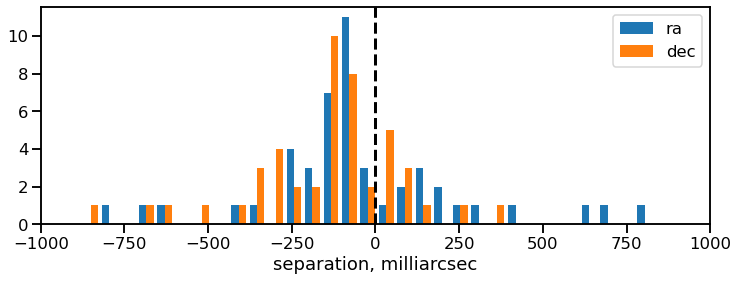

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist([ra, dec], bins=31, label=["ra", "dec"])
ax.set(xlabel="separation, milliarcsec", yscale="linear", xlim=limits)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend()
...;

In [37]:
ra_mean, ra_median, ra_std = sigma_clipped_stats(ra, sigma=2.0)
dec_mean, dec_median, dec_std = sigma_clipped_stats(dec, sigma=2.0)

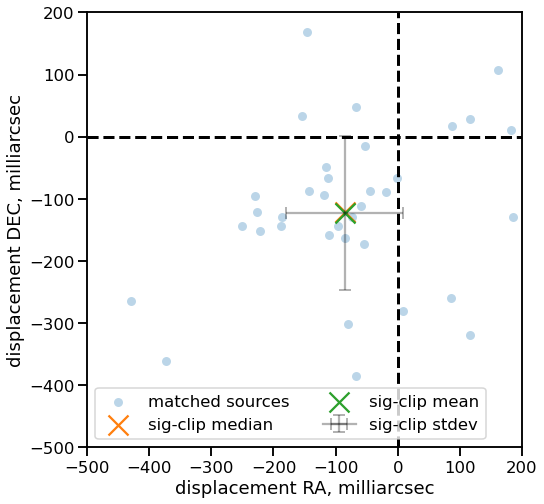

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.3, linewidths=0, label="matched sources")
ax.scatter(ra_median, dec_median, marker="x", s=400, label="sig-clip median")
ax.scatter(ra_mean, dec_mean, marker="x", s=400, label="sig-clip mean")
ax.errorbar(ra_mean, dec_mean, xerr=ra_std, yerr=dec_std, color="k", capsize=6, capthick=2, alpha=0.3, label="sig-clip stdev")
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend(ncol=2)
ax.set(
    xlim=[-500, 200],
    ylim=[-500, 200],
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")

In [39]:
hdu2.header["CRVAL1"] -= Angle(ra_median * u.milliarcsecond).deg
hdu2.header["CRVAL2"] -= Angle(dec_median * u.milliarcsecond).deg
newname2 = f"align-{fname2}"
hdu2.writeto(datapath / f"{newname2}.fits", overwrite=True)

## Repeat for F673N

In [40]:
fname2 = "pcmos-f673n_sharp_16"
hdu2, = fits.open(datapath / f"{fname2}.fits")
w2 = WCS(hdu2.header)
stab2 = Table.read(datapath / f"{fname2}-sources-{sname2}.ecsv")
c2 = w2.pixel_to_world(stab2["xcentroid"], stab2["ycentroid"])

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


In [41]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
c1_matches = c1[sep_constraint]
c2_matches = c2[idx[sep_constraint]]
f"Out of {len(c1)} sources in catalog #1 we have {len(c1_matches)} in catalog #2, but only {len(set(idx[sep_constraint]))} are unique."

'Out of 404 sources in catalog #1 we have 125 in catalog #2, but only 55 are unique.'

In [42]:
stab1_matches = stab1[sep_constraint]
stab2_matches = stab2[idx[sep_constraint]]
ii1, ii2 = match_catalogs(c1, c2, max_sep=max_sep)
c1m = c1[ii1]
c2m = c2[ii2]
seps = c1m.separation(c2m)

In [43]:
offsets = c1m.spherical_offsets_to(c2m)
ra, dec = [_.milliarcsecond for _ in offsets]
max_sep_mas = max_sep.to(u.milliarcsecond).value
limits = [-max_sep_mas, max_sep_mas]

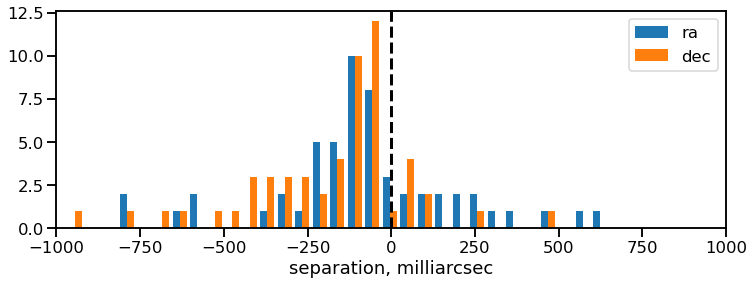

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist([ra, dec], bins=31, label=["ra", "dec"])
ax.set(xlabel="separation, milliarcsec", yscale="linear", xlim=limits)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend()
...;

In [45]:
ra_mean, ra_median, ra_std = sigma_clipped_stats(ra, sigma=2.0)
dec_mean, dec_median, dec_std = sigma_clipped_stats(dec, sigma=2.0)

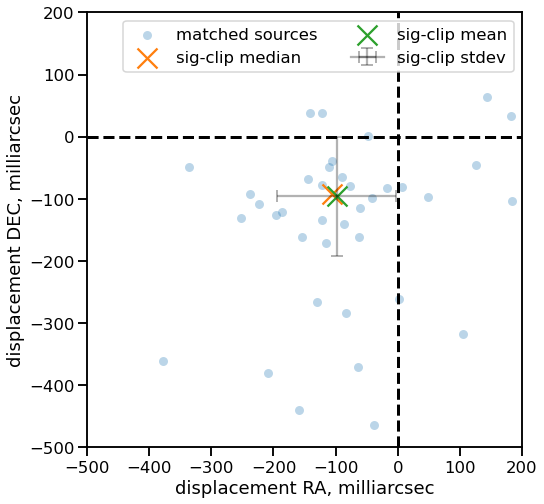

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.3, linewidths=0, label="matched sources")
ax.scatter(ra_median, dec_median, marker="x", s=400, label="sig-clip median")
ax.scatter(ra_mean, dec_mean, marker="x", s=400, label="sig-clip mean")
ax.errorbar(ra_mean, dec_mean, xerr=ra_std, yerr=dec_std, color="k", capsize=6, capthick=2, alpha=0.3, label="sig-clip stdev")
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend(ncol=2)
ax.set(
    xlim=[-500, 200],
    ylim=[-500, 200],
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")

In [47]:
hdu2.header["CRVAL1"] -= Angle(ra_median * u.milliarcsecond).deg
hdu2.header["CRVAL2"] -= Angle(dec_median * u.milliarcsecond).deg
newname2 = f"align-{fname2}"
hdu2.writeto(datapath / f"{newname2}.fits", overwrite=True)

## Repeat for F658N

In [48]:
fname2 = "pcmos-f658n_sharp_16"
hdu2, = fits.open(datapath / f"{fname2}.fits")
w2 = WCS(hdu2.header)
stab2 = Table.read(datapath / f"{fname2}-sources-{sname2}.ecsv")
c2 = w2.pixel_to_world(stab2["xcentroid"], stab2["ycentroid"])

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


In [49]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
c1_matches = c1[sep_constraint]
c2_matches = c2[idx[sep_constraint]]
f"Out of {len(c1)} sources in catalog #1 we have {len(c1_matches)} in catalog #2, but only {len(set(idx[sep_constraint]))} are unique."

'Out of 404 sources in catalog #1 we have 115 in catalog #2, but only 41 are unique.'

In [50]:
stab1_matches = stab1[sep_constraint]
stab2_matches = stab2[idx[sep_constraint]]
ii1, ii2 = match_catalogs(c1, c2, max_sep=max_sep)
c1m = c1[ii1]
c2m = c2[ii2]
seps = c1m.separation(c2m)

In [51]:
offsets = c1m.spherical_offsets_to(c2m)
ra, dec = [_.milliarcsecond for _ in offsets]
max_sep_mas = max_sep.to(u.milliarcsecond).value
limits = [-max_sep_mas, max_sep_mas]

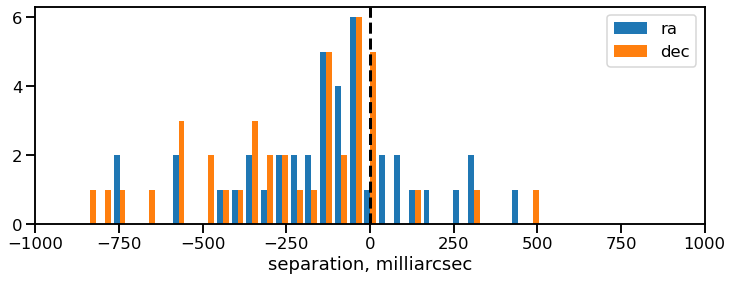

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist([ra, dec], bins=31, label=["ra", "dec"])
ax.set(xlabel="separation, milliarcsec", yscale="linear", xlim=limits)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend()
...;

In [53]:
ra_mean, ra_median, ra_std = sigma_clipped_stats(ra, sigma=2.0)
dec_mean, dec_median, dec_std = sigma_clipped_stats(dec, sigma=2.0)

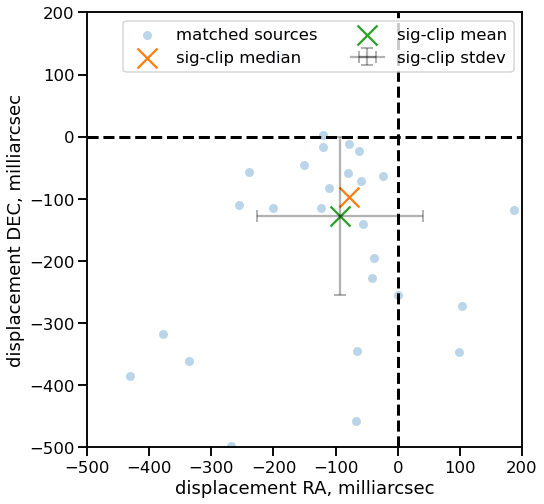

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.3, linewidths=0, label="matched sources")
ax.scatter(ra_median, dec_median, marker="x", s=400, label="sig-clip median")
ax.scatter(ra_mean, dec_mean, marker="x", s=400, label="sig-clip mean")
ax.errorbar(ra_mean, dec_mean, xerr=ra_std, yerr=dec_std, color="k", capsize=6, capthick=2, alpha=0.3, label="sig-clip stdev")
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend(ncol=2)
ax.set(
    xlim=[-500, 200],
    ylim=[-500, 200],
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")

In [55]:
hdu2.header["CRVAL1"] -= Angle(ra_median * u.milliarcsecond).deg
hdu2.header["CRVAL2"] -= Angle(dec_median * u.milliarcsecond).deg
newname2 = f"align-{fname2}"
hdu2.writeto(datapath / f"{newname2}.fits", overwrite=True)

## Repeat for F656N

In [56]:
fname2 = "pcmos-f656n_sharp_16"
hdu2, = fits.open(datapath / f"{fname2}.fits")
w2 = WCS(hdu2.header)
stab2 = Table.read(datapath / f"{fname2}-sources-{sname2}.ecsv")
c2 = w2.pixel_to_world(stab2["xcentroid"], stab2["ycentroid"])

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


In [57]:
max_sep = 1.0 * u.arcsec
idx, d2d, d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d < max_sep
c1_matches = c1[sep_constraint]
c2_matches = c2[idx[sep_constraint]]
f"Out of {len(c1)} sources in catalog #1 we have {len(c1_matches)} in catalog #2, but only {len(set(idx[sep_constraint]))} are unique."

'Out of 404 sources in catalog #1 we have 114 in catalog #2, but only 38 are unique.'

In [58]:
stab1_matches = stab1[sep_constraint]
stab2_matches = stab2[idx[sep_constraint]]
ii1, ii2 = match_catalogs(c1, c2, max_sep=max_sep)
c1m = c1[ii1]
c2m = c2[ii2]
seps = c1m.separation(c2m)

In [59]:
offsets = c1m.spherical_offsets_to(c2m)
ra, dec = [_.milliarcsecond for _ in offsets]
max_sep_mas = max_sep.to(u.milliarcsecond).value
limits = [-max_sep_mas, max_sep_mas]

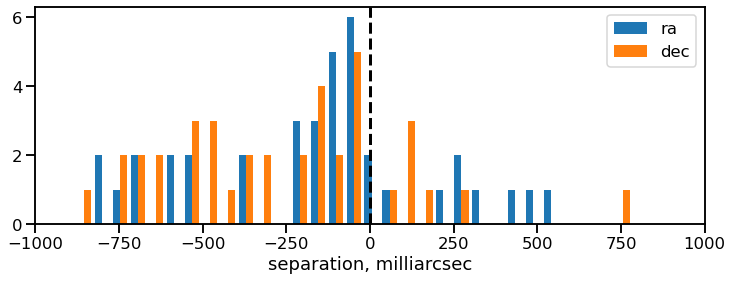

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist([ra, dec], bins=31, label=["ra", "dec"])
ax.set(xlabel="separation, milliarcsec", yscale="linear", xlim=limits)
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend()
...;

In [65]:
ra_mean, ra_median, ra_std = sigma_clipped_stats(ra, sigma=1.5)
dec_mean, dec_median, dec_std = sigma_clipped_stats(dec, sigma=1.5)

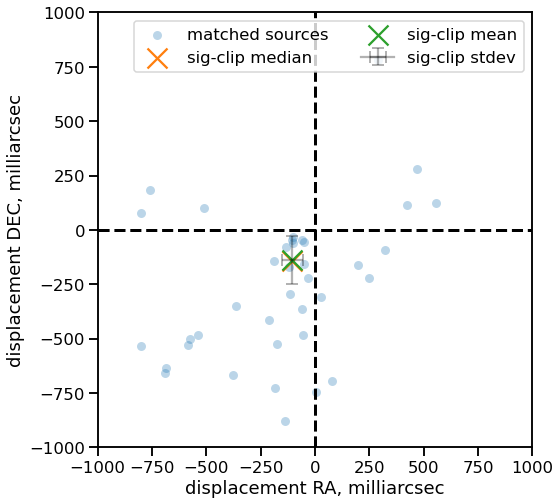

In [67]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ra, dec, alpha=0.3, linewidths=0, label="matched sources")
ax.scatter(ra_median, dec_median, marker="x", s=400, label="sig-clip median")
ax.scatter(ra_mean, dec_mean, marker="x", s=400, label="sig-clip mean")
ax.errorbar(ra_mean, dec_mean, xerr=ra_std, yerr=dec_std, color="k", capsize=6, capthick=2, alpha=0.3, label="sig-clip stdev")
ax.axvline(0.0, color="k", lw=3, linestyle="dashed")
ax.axhline(0.0, color="k", lw=3, linestyle="dashed")
ax.legend(ncol=2)
ax.set(
    xlim=[-1000, 1000],
    ylim=[-1000, 1000],
    xlabel="displacement RA, milliarcsec", ylabel="displacement DEC, milliarcsec",
)

ax.set_aspect("equal")

In [68]:
hdu2.header["CRVAL1"] -= Angle(ra_median * u.milliarcsecond).deg
hdu2.header["CRVAL2"] -= Angle(dec_median * u.milliarcsecond).deg
newname2 = f"align-{fname2}"
hdu2.writeto(datapath / f"{newname2}.fits", overwrite=True)